## Laboratoire 2

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from deeplib.visualization import make_vizualization_autograd

### Graphe computationnel et backprop
Cette section a pour but de vous familiariser avec les notions de graphe computationnel et de backpropagation, plus particulièrement leur implémentation PyTorch. Dans le dernier laboratoire, vous avez vu une version haut-niveau de l'entraînement de réseaux de neurones. À l'inverse, ce laboratoire a pour but de vous donner une intuition du fonctionnement interne de PyTorch. Qui sait? Peut-être voudrai vous un jour implémenter vous même votre librairie de graphe de calcul.

#### Tenseurs et Variables
La structure de données de base dans PyTorch est le `Tensor`. Cette structure de données est comparable au `ndarray` numpy. Le package `torch.Tensor` défini des matrices multidimensionnelles et les opérations sur celles-ci. Voici quelques exemples: 

In [2]:
# Création et initialisation à une normale centrée à 0 et de variance 1.
a = torch.Tensor(10,10)
print(a) # Initialement, le tenseur contient du 'garbage'. Il peut même contenir des NaN
a.normal_()
print(a)
print(torch.mean(a))

tensor([[ 1.5590e-19,  4.5776e-41, -1.3082e+02,  3.0894e-41,  1.9074e-19,
          4.5776e-41,  4.2469e-23,  4.5776e-41,  1.9077e-19,  4.5776e-41],
        [ 4.6276e-20,  4.5776e-41,  1.6491e-20,  4.5776e-41, -6.7367e-17,
          4.5775e-41, -6.7367e-17,  4.5775e-41,  4.2556e-23,  4.5776e-41],
        [ 4.7232e-20,  4.5776e-41,  1.9084e-19,  4.5776e-41,  5.0848e-21,
          4.5776e-41,  8.1273e-22,  4.5776e-41, -6.7368e-17,  4.5775e-41],
        [ 4.1538e-21,  4.5776e-41,  1.9081e-19,  4.5776e-41,  1.9081e-19,
          4.5776e-41, -6.7369e-17,  4.5775e-41,  2.7458e-20,  4.5776e-41],
        [ 1.9078e-19,  4.5776e-41, -6.7369e-17,  4.5775e-41,  4.7966e-20,
          4.5776e-41,  4.9939e-36,  4.5776e-41, -6.7370e-17,  4.5775e-41],
        [ 4.7663e-20,  4.5776e-41, -6.7165e-17,  4.5775e-41, -6.7370e-17,
          4.5775e-41,  1.9078e-19,  4.5776e-41,  4.8121e-20,  4.5776e-41],
        [ 1.8754e-19,  4.5776e-41, -6.7372e-17,  4.5775e-41, -9.3459e+26,
          4.5775e-41,  4.6390e-2

> **REMARQUE** Dans l'exemple précédent, la méthode `normal_()` se termine par un underscore. Cela signifie que cette méthode fait une mutation du `Tensor`.

In [4]:
b = torch.Tensor(10,1).fill_(1)
print(b.shape)
print(b)
print(a.matmul(b))
print(torch.matmul(a,b))

torch.Size([10, 1])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
tensor([[ 2.1041],
        [-1.2153],
        [-0.7759],
        [ 1.4701],
        [ 2.0024],
        [ 4.0777],
        [ 0.9287],
        [ 6.8218],
        [ 0.7157],
        [-1.1556]])
tensor([[ 2.1041],
        [-1.2153],
        [-0.7759],
        [ 1.4701],
        [ 2.0024],
        [ 4.0777],
        [ 0.9287],
        [ 6.8218],
        [ 0.7157],
        [-1.1556]])


On peut facilement transférer un `Tensor` sur GPU. Les opérations sur ces `Tensor` seront exécutées sur GPU.

In [5]:
a_gpu = a.cuda()
b_gpu = b.cuda()
print(a_gpu.matmul(b_gpu))
print(a_gpu.matmul(b_gpu).cpu())

tensor([[ 2.1041],
        [-1.2153],
        [-0.7759],
        [ 1.4701],
        [ 2.0024],
        [ 4.0777],
        [ 0.9287],
        [ 6.8218],
        [ 0.7157],
        [-1.1556]], device='cuda:0')
tensor([[ 2.1041],
        [-1.2153],
        [-0.7759],
        [ 1.4701],
        [ 2.0024],
        [ 4.0777],
        [ 0.9287],
        [ 6.8218],
        [ 0.7157],
        [-1.1556]])


In [8]:
#TODO corrigez cette opération pour multiplier `a` avec `c_gpu` sur cpu
c_gpu = a_gpu.matmul(b_gpu)
print(a.matmul(c_gpu.cpu()))

tensor([[ 12.2578],
        [  7.0267],
        [  1.2094],
        [  2.2110],
        [  3.8236],
        [  4.7194],
        [  0.9831],
        [ -2.7468],
        [  6.0601],
        [-13.2197]])


Depuis PyTorch 1.0, l'API Variable est discontinué. Nous pouvons simplement spécifier ```requires_grad=True``` au Tensor en question pour activer le calcul des gradients.

In [9]:
a.requires_grad = True
b.requires_grad = True
a, b

(tensor([[-0.8747, -0.8200,  1.3919, -0.5486, -0.1311,  1.0769,  0.9269,  1.3295,
           0.3440, -0.5908],
         [-0.4700, -0.2279, -0.9211, -0.3658,  0.6537, -0.0910, -1.4320,  1.1289,
           0.4500,  0.0600],
         [ 0.8219, -0.2285, -1.2478, -0.4242,  0.7023, -0.9819, -1.2189,  0.3657,
           0.9360,  0.4996],
         [ 0.6118, -0.9927,  1.3664, -0.3111, -0.0812,  1.2424, -0.1977, -0.5466,
           0.3645,  0.0145],
         [ 0.4405,  0.1221, -0.3015,  1.8236,  0.0288, -0.7720, -0.7149,  0.7312,
          -0.1916,  0.8362],
         [-0.3846, -0.1187, -0.2144,  0.4989,  0.0440,  1.1247,  0.2569, -0.1253,
           2.0778,  0.9184],
         [ 1.3739,  0.3370,  1.1351, -1.4363, -1.1215,  0.6176, -0.8329,  0.1749,
           0.8489, -0.1680],
         [ 0.0533,  2.3684,  0.5614,  0.4163,  1.7210,  0.1279,  1.0950, -0.4916,
          -0.3567,  1.3267],
         [ 0.3316,  0.7710, -1.1686,  0.3750,  0.0100,  0.3215, -0.9116,  0.7758,
          -0.3693,  0.5805],
 

En règle générale, les opérations in-place, c'est-à-dire les opérations qui font une mutation directe d'un ```Tensor``` (et qui se terminent par un underscore), ne sont pas disponibles lorsque ```requires_grad``` est égale à ```True```.

In [2]:
a.uniform_()

NameError: name 'a' is not defined

```Tensor``` contient quelques attributs intéressant comme les données et le gradient.

In [11]:
print(type(a))
print(type(a.data))
print(a.grad)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
None


Nous allons voir dans la prochaine section comment faire la backpropagation du gradient.

#### Gradient et Backpropagation

Variable provient du package `torch.autograd`. Comme le nom du package l'indique, il est possible d'automatiquement calculer la dérivée de fonctions calculées à partir d'opérations sur les variables. On indique les Variables qu'on veut dériver avec `requires_grad=True` (par défaut à False). Dans l'exemple suivant, lors du calcul de `w` (propagation avant), PyTorch construit dynamiquement un graphe de calcul indiquant les liens de dépendance entre les variables et les opérations, ce qui permet la backpropagation.

> **NOTE** Contrairement à des librairies comme Tensorflow où le graphe de calcul est statique, PyTorch recrée dynamique le graphe de calcul à chaque itération. Cela permet de modifier la structure du graphe dynamiquement avec du code Python. Par contre, cela rend la visualisation du graphe plus difficile. 


In [3]:
x = torch.Tensor(3, 3).uniform_(-1, 1)

y = torch.Tensor(3, 3).uniform_(-1, 1)
y.requires_grad = True

z = torch.Tensor(3, 3).uniform_(-1, 1)
z.requires_grad = True

f = torch.matmul(x, y) + x + y + z

print(x, y, z, f)

tensor([[ 0.8974, -0.8265, -0.7917],
        [-0.3225, -0.7398,  0.1353],
        [ 0.1981, -0.1445,  0.2961]]) tensor([[ 0.3841,  0.0928, -0.8389],
        [ 0.8502,  0.5531, -0.3166],
        [-0.7131,  0.1650,  0.1098]], requires_grad=True) tensor([[-0.3612,  0.6629, -0.5413],
        [-0.9794,  0.3792, -0.1483],
        [-0.2481, -0.5393, -0.9957]], requires_grad=True) tensor([[ 1.1268, -0.5753, -2.7499],
        [-1.3011, -0.2242,  0.1900],
        [-1.0210, -0.5316, -0.6777]], grad_fn=<AddBackward0>)


None
None
None
None


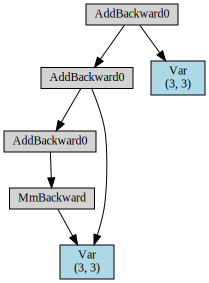

In [13]:
print(f.grad_fn)

print(x.grad)
print(y.grad)
print(z.grad)
print(f.grad)

make_vizualization_autograd(f)

In [6]:
f_grad = torch.ones(f.size())
f.backward(f_grad)

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [5]:
print(x.grad)
print(y.grad)
print(z.grad)
print(f.grad)

None
tensor([[ 1.7730,  1.7730,  1.7730],
        [-0.7108, -0.7108, -0.7108],
        [ 0.6397,  0.6397,  0.6397]])
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
None


##### Questions
- Exécutez deux fois la cellule qui appelle la fonction .backward(). Qu'arrive-t-il? Pourquoi?
- Quelles tensors auraient requires_grad=False dans le contexte d'entraînement de réseaux de neurones?
- Dans l'exemple précédent, pourquoi `f` n'a-t-il pas de gradient?

##### TODO exercice
Faites la mise-à-jour des valeurs de y et z et soustrayant $1 \times 10^{-3}$ fois leur gradient

In [12]:
# TODO
y = y - torch.Tensor(3, 3).fill_(0.001)
z = y - torch.Tensor(3, 3).fill_(0.001)

In [13]:
print(y)
print(z)

tensor([[ 0.3821,  0.0908, -0.8409],
        [ 0.8482,  0.5511, -0.3186],
        [-0.7151,  0.1630,  0.1078]], grad_fn=<SubBackward0>)
tensor([[ 0.3811,  0.0898, -0.8419],
        [ 0.8472,  0.5501, -0.3196],
        [-0.7161,  0.1620,  0.1068]], grad_fn=<SubBackward0>)


#### Prévenir le calcul de gradient

Pour éviter de caluler les gradients pour certains tensor, nous utiliserons la méthode `torch.no_grad()`.

In [ ]:
x = torch.Tensor(3, 3).uniform_(-1, 1)

y = torch.Tensor(3, 3).uniform_(-1, 1)
y.requires_grad = True

z = torch.Tensor(3, 3).uniform_(-1, 1)
z.requires_grad = True

f = torch.matmul(x, y) + x + y + z

print(f.requires_grad)

In [ ]:
with torch.no_grad():
    f = torch.matmul(x, y) + x + y + z

print(f.requires_grad)

##### Question
- Dans quel contexte voudrait-on ne calculer aucun gradient d'un graphe de calcul?

Dans un contexte d,apprentissage par transfert peut-être?

### Fonction d'activation

La section suivante a pour but d'explorer les différences entre les fonctions d'activation ReLU et Tanh.

#### Question préalable
- À quoi sert la fonction d'activation? Sans elle, que devient un réseau multi-couches? Pour ajouter de la non-linaérité dans les réseaux. Sans elles, les réseaux de neurones ne sont qu'une suite d'équations linéaires.

#### Visualisation du dataset
Pour cette partie, nous utiliserons le dataset des spirales. Vous pouvez voir le code qui a servi à générer le dataset dans la librairie https://github.com/ulaval-damas/glo4030-labs/blob/master/deeplib/datasets.py

(1000, 7) (1000,)


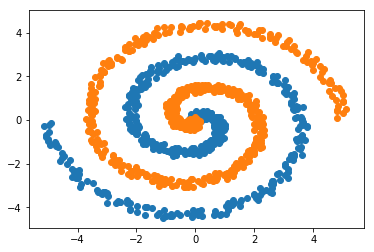

In [2]:
from deeplib.datasets import SpiralDataset, train_valid_loaders

dataset = SpiralDataset()
points, labels = dataset.to_numpy()
print(points.shape, labels.shape)
plt.scatter(points[labels==1,0], points[labels==1,1])
plt.scatter(points[labels==0,0], points[labels==0,1])

Dans la cellule suivante,  `train_valid_loaders()` retourne des [DataLoader](http://pytorch.org/docs/0.3.0/data.html#torch.utils.data.DataLoader) pytorch. Il est possible d'itérer sur les données d'un `DataLoader` comme on le ferait sur un liste python.

> **PYTHON DEEP DIVE** Pourquoi peut-on itérer facilement sur le `DataLoader`? Parce que la classe implémente la méthode `__iter__`. Ainsi, quand on fait
```
for x in data_loader:
```
la fonction `__iter__` est appelée, ce qui crée un itérateur sur le `DataLoader`. Cet itérateur peut charger les données sur demande puis que la méthode `__next__` est appelée à chaque itération. Il est possible de créer explicitement cet itérateur en appelant la fonction built-in `iter()`.

In [3]:
train_loader, valid_loader = train_valid_loaders(dataset, 8)

for i, (data, label) in enumerate(train_loader):
    print(data, label)
    if i > 10:
        break

tensor([[-2.0562,  3.7494,  4.2281, 14.0583, -7.7097, -0.8845, -0.5711],
        [ 1.1466,  4.3743,  1.3146, 19.1349,  5.0155,  0.9114, -0.9434],
        [ 3.0784,  1.2092,  9.4766,  1.4621,  3.7223,  0.0631,  0.9353],
        [ 2.8220, -2.4410,  7.9640,  5.9587, -6.8888,  0.3141, -0.6446],
        [ 0.1456,  0.3361,  0.0212,  0.1129,  0.0489,  0.1451,  0.3298],
        [ 0.6513,  1.5041,  0.4242,  2.2622,  0.9796,  0.6062,  0.9978],
        [-0.2806, -0.1386,  0.0788,  0.0192,  0.0389, -0.2770, -0.1381],
        [ 2.1678,  2.1872,  4.6993,  4.7839,  4.7414,  0.8270,  0.8160]]) tensor([0, 0, 1, 1, 1, 0, 0, 1])
tensor([[-3.5568e+00,  1.6518e+00,  1.2651e+01,  2.7283e+00, -5.8750e+00,
          4.0339e-01,  9.9672e-01],
        [ 1.3142e+00, -3.8051e+00,  1.7271e+00,  1.4479e+01, -5.0006e+00,
          9.6725e-01,  6.1591e-01],
        [ 8.3000e-01, -3.4228e-01,  6.8890e-01,  1.1716e-01, -2.8409e-01,
          7.3793e-01, -3.3564e-01],
        [-1.9542e+00,  7.0542e-01,  3.8190e+00,  4.9

Comme pour tout itérateur python, on peut utiliser `itertools`. Par exemple, ici, on boucle sur les 10 premiers éléments de l'itérateur:

In [4]:
import itertools
for data in itertools.islice(iter(train_loader), 10):
    print(data)

[tensor([[ 3.2536, -1.5859, 10.5860,  2.5152, -5.1601, -0.1118, -0.9999],
        [ 0.2930,  1.4614,  0.0859,  2.1358,  0.4283,  0.2889,  0.9940],
        [-2.2086, -0.4160,  4.8778,  0.1730,  0.9187, -0.8034, -0.4041],
        [ 3.6156, -0.2495, 13.0723,  0.0622, -0.9019, -0.4564, -0.2469],
        [ 1.2481, -3.9066,  1.5577, 15.2614, -4.8758,  0.9484,  0.6925],
        [ 2.2139, -0.3047,  4.9014,  0.0929, -0.6747,  0.8002, -0.3001],
        [ 1.8709, -1.4837,  3.5002,  2.2013, -2.7758,  0.9553, -0.9962],
        [ 1.9988, -3.3706,  3.9952, 11.3609, -6.7371,  0.9098,  0.2270]]), tensor([1, 0, 1, 1, 1, 0, 0, 1])]
[tensor([[ 1.9770e+00,  7.2144e-01,  3.9083e+00,  5.2047e-01,  1.4262e+00,
          9.1865e-01,  6.6047e-01],
        [ 3.6250e+00, -1.5907e+00,  1.3141e+01,  2.5302e+00, -5.7661e+00,
         -4.6481e-01, -9.9980e-01],
        [ 1.8856e-01, -4.1373e+00,  3.5556e-02,  1.7117e+01, -7.8014e-01,
          1.8745e-01,  8.3915e-01],
        [ 3.5657e+00, -1.2319e+00,  1.2714e+01, 

In [5]:
print(next(iter(train_loader)))

[tensor([[ 2.1454e+00, -1.1368e+00,  4.6026e+00,  1.2924e+00, -2.4390e+00,
          8.3943e-01, -9.0731e-01],
        [ 2.2023e+00, -5.7698e-01,  4.8501e+00,  3.3291e-01, -1.2707e+00,
          8.0715e-01, -5.4550e-01],
        [-7.7052e-01,  2.5196e+00,  5.9370e-01,  6.3484e+00, -1.9414e+00,
         -6.9651e-01,  5.8265e-01],
        [ 5.2080e-01, -1.2755e+00,  2.7124e-01,  1.6268e+00, -6.6426e-01,
          4.9758e-01, -9.5670e-01],
        [ 7.9286e-01,  3.0645e+00,  6.2863e-01,  9.3914e+00,  2.4297e+00,
          7.1236e-01,  7.6978e-02],
        [ 1.3798e+00,  1.3016e+00,  1.9040e+00,  1.6941e+00,  1.7960e+00,
          9.8182e-01,  9.6398e-01],
        [ 3.6364e-01,  6.5647e-02,  1.3223e-01,  4.3096e-03,  2.3872e-02,
          3.5568e-01,  6.5600e-02],
        [ 5.2534e-01,  1.2985e-01,  2.7598e-01,  1.6861e-02,  6.8216e-02,
          5.0151e-01,  1.2949e-01]]), tensor([0, 0, 1, 1, 1, 0, 1, 1])]


#### Création de modèles

Ici, on crée des classes qui héritent de `torch.nn.Module`. C'est la classe de base de tout réseau dans pytorch. `Module` comporte par exemple la méthode `named_parameters()` qui permet d'obtenir toutes les variables entraînables du `Module` ainsi que leur nom. Voici un lien vers la documentation complète:
http://pytorch.org/docs/0.3.0/nn.html#torch.nn.Module.

##### Exercice
Écrivez la fonction forward de TanhModel et ReluModel

In [188]:
class RandomModel(torch.nn.Module):
    
    def __init__(self, n_layers):
        super().__init__()
        torch.manual_seed(12345) # Both Tanh model and ReLU model will have the same random weights
        
        self.layers = []
        for i in range(n_layers):
            layer = nn.Linear(7,7)
            layer.weight.data.normal_(0.0, math.sqrt(2 / 7))
            layer.bias.data.fill_(0)
            self.layers.append(layer)
            self.add_module('layer-%d' % i, layer)
        self.output_layer = nn.Linear(7,2)

        self.nonzero_grad_stats = None
        
    
    def forward(self):
        raise NotImplementedError('Defined in children classes')
       
    
    def _forward_output_layer(self, x):
        out = self.output_layer.forward(x)
        out = F.log_softmax(out, dim=1)
        return out
        
    
    def print_weights_grads(self):
        self.nonzero_grad_stats = []
        for i, layer in enumerate(self.layers):
            print("-----\nLayer %d" % i)
            print("Weight:\n%sWeight gradient:\n%s\n" % (str(layer.weight.data), 
                                                         str(layer.weight.grad)))
            if layer.weight.grad is not None:
                nonzero_grad_indices = torch.nonzero(layer.weight.grad.data)
                nonzero_grad = [layer.weight.grad.data[i,j] for (i,j) in nonzero_grad_indices]
                nonzero_grad_mean = np.mean(np.abs(nonzero_grad))
                self.nonzero_grad_stats.append((len(nonzero_grad), nonzero_grad_mean))
                print("Number of nonzero gradient: %f" % len(nonzero_grad))
                print("Nonzero grad mean: %f" % nonzero_grad_mean)
        

        
class RandomReluModel(RandomModel):
    
    def __init__(self, n_layers):
        super().__init__(n_layers)
        
    
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer.forward(out)
            out = F.relu(out)
        return self._forward_output_layer(out)
        
        
        
class RandomTanhModel(RandomModel):
    
    def __init__(self, n_layers):
        super().__init__(n_layers)
        
    
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer.forward(out)
            out = torch.tanh(out)
        return self._forward_output_layer(out)

In [189]:
relu_model = RandomReluModel(10)
tanh_model = RandomTanhModel(10)
relu_model.print_weights_grads()
tanh_model.print_weights_grads()

-----
Layer 0
Weight:
tensor([[-0.3526, -0.7481, -0.3664, -0.0214,  0.8256,  0.6263, -0.2033],
        [ 0.9266,  0.4668,  0.5364,  0.8169,  0.2559, -0.7068, -0.1350],
        [-1.1160, -0.3064, -0.7955,  0.2473,  0.4237,  1.0606, -0.2491],
        [ 1.0780, -0.5208,  0.2758,  0.0120, -0.6570,  0.1587,  0.9044],
        [ 0.1614,  0.0300, -0.2369,  0.3602, -0.1150,  0.2094, -0.5939],
        [ 0.2099,  0.0067, -0.1007,  0.0333, -0.0764, -0.0471, -0.1293],
        [-0.4333,  0.5793,  0.1326,  0.7287,  0.5808, -0.0513,  0.4890]])Weight gradient:
None

-----
Layer 1
Weight:
tensor([[ 0.0242,  0.1164,  0.4192, -0.9414,  0.9430,  0.1859,  0.3455],
        [ 0.3670,  0.8510,  0.2315, -0.3758,  0.1511,  0.8824,  0.2419],
        [ 0.1758,  0.0703, -0.6284, -0.5292, -0.9301, -1.1800,  0.2042],
        [ 1.1206, -0.1256, -0.2281,  0.1875,  0.4249,  0.1399, -0.0889],
        [ 1.0258,  0.5543,  0.4392, -0.1527, -0.7752, -0.2811, -0.1861],
        [-0.1664, -0.2569, -0.3510, -0.9809,  0.5899,  0.

In [190]:
data_in, data_out = next(iter(train_loader))
print(Variable(data_in))

tensor([[ 3.0891e-02,  2.7733e-01,  9.5426e-04,  7.6914e-02,  8.5671e-03,
          3.0886e-02,  2.7379e-01],
        [ 3.7704e+00, -3.3640e-01,  1.4216e+01,  1.1316e-01, -1.2684e+00,
         -5.8819e-01, -3.3009e-01],
        [ 2.3097e+00, -6.6663e-01,  5.3348e+00,  4.4440e-01, -1.5397e+00,
          7.3920e-01, -6.1834e-01],
        [-1.1706e+00, -1.1360e+00,  1.3702e+00,  1.2905e+00,  1.3298e+00,
         -9.2097e-01, -9.0696e-01],
        [ 1.0102e+00, -2.2159e-01,  1.0206e+00,  4.9102e-02, -2.2386e-01,
          8.4696e-01, -2.1978e-01],
        [ 3.8520e-01,  4.4406e+00,  1.4838e-01,  1.9719e+01,  1.7105e+00,
          3.7574e-01, -9.6330e-01],
        [-1.7585e-03, -2.5247e-01,  3.0922e-06,  6.3741e-02,  4.4396e-04,
         -1.7585e-03, -2.4980e-01],
        [-6.2620e-01, -1.3318e+00,  3.9212e-01,  1.7738e+00,  8.3400e-01,
         -5.8607e-01, -9.7159e-01]])


In [191]:
data_in, data_out = next(iter(train_loader))
relu_output = relu_model.forward(Variable(data_in))
tanh_output = tanh_model.forward(Variable(data_in))
print("ReLU model ouput:\n", relu_output)
print("tanh model ouput:\n", tanh_output)
print(Variable(data_out))

ReLU model ouput:
 tensor([[-0.8042, -0.5932],
        [-0.7974, -0.5987],
        [-0.7974, -0.5987],
        [-1.0884, -0.4106],
        [-0.8448, -0.5615],
        [-0.7974, -0.5987],
        [-0.8363, -0.5680],
        [-0.8084, -0.5898]], grad_fn=<LogSoftmaxBackward>)
tanh model ouput:
 tensor([[-0.7325, -0.6552],
        [-0.7614, -0.6292],
        [-0.7612, -0.6294],
        [-0.8626, -0.5483],
        [-0.8638, -0.5474],
        [-0.8440, -0.5621],
        [-0.7726, -0.6195],
        [-0.7326, -0.6552]], grad_fn=<LogSoftmaxBackward>)
tensor([0, 1, 0, 0, 0, 1, 1, 0])


#### TODO Exercice
Vérifiez que le réseau retourne bel et bien des probabilités. Identifiez la ligne de code qui transforme des nombres arbitraires en probabilité. Indice: il y a une erreur volontaire dans le code que vous devez corriger.

#### Analyse du modèle

In [192]:
loss = torch.nn.NLLLoss()
relu_loss = loss(relu_output, Variable(data_out))
tanh_loss = loss(tanh_output, Variable(data_out))
print(relu_loss, tanh_loss)

tensor(0.7636, grad_fn=<NllLossBackward>) tensor(0.7205, grad_fn=<NllLossBackward>)


In [193]:
relu_loss.backward()
tanh_loss.backward()
relu_model.print_weights_grads()
tanh_model.print_weights_grads()

-----
Layer 0
Weight:
tensor([[-0.3526, -0.7481, -0.3664, -0.0214,  0.8256,  0.6263, -0.2033],
        [ 0.9266,  0.4668,  0.5364,  0.8169,  0.2559, -0.7068, -0.1350],
        [-1.1160, -0.3064, -0.7955,  0.2473,  0.4237,  1.0606, -0.2491],
        [ 1.0780, -0.5208,  0.2758,  0.0120, -0.6570,  0.1587,  0.9044],
        [ 0.1614,  0.0300, -0.2369,  0.3602, -0.1150,  0.2094, -0.5939],
        [ 0.2099,  0.0067, -0.1007,  0.0333, -0.0764, -0.0471, -0.1293],
        [-0.4333,  0.5793,  0.1326,  0.7287,  0.5808, -0.0513,  0.4890]])Weight gradient:
tensor([[-4.4073e-03,  9.4562e-03,  2.9629e-02,  2.6721e-02,  2.3525e-02,
          3.2253e-03, -1.9325e-03],
        [ 2.0017e-03,  4.5895e-03,  9.5923e-04,  2.2134e-02, -1.1493e-03,
          1.1804e-03,  3.0968e-04],
        [ 1.4028e-03,  1.9584e-03,  1.9194e-03,  3.9070e-02,  7.8339e-03,
          1.0667e-03, -2.0237e-03],
        [ 3.6422e-03,  3.2792e-03, -2.2130e-02, -1.9809e-02, -7.9859e-04,
         -1.7375e-03, -1.3564e-03],
        [ 

Le graphique suivant représente la quantité de poids qui ont un gradient nul lors de la backprop en fonction du numéro de la couche. 

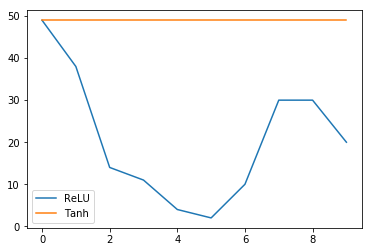

In [194]:
plt.plot(np.arange(len(relu_model.nonzero_grad_stats)), [x[0] for x in relu_model.nonzero_grad_stats], label='ReLU')
plt.plot(np.arange(len(tanh_model.nonzero_grad_stats)), [x[0] for x in tanh_model.nonzero_grad_stats], label='Tanh')
plt.legend()

Le graphique suivant représente le gradient moyen (sans tenir compte des gradients nuls) en fonction du numéro de couche. La partie du bas est un zoom sur les premières couches.

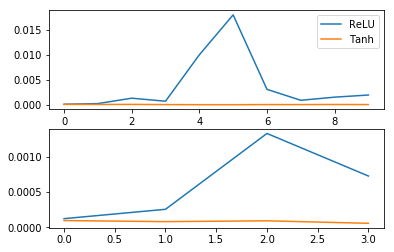

In [195]:
fig, axs = plt.subplots(2)
axs[0].plot(np.arange(len(relu_model.nonzero_grad_stats)), [x[1] / x[0] for x in relu_model.nonzero_grad_stats],label='ReLU')
axs[0].plot(np.arange(len(tanh_model.nonzero_grad_stats)), [x[1] / x[0] for x in tanh_model.nonzero_grad_stats],label='Tanh')
axs[0].legend()
axs[1].plot(np.arange(4), [x[1] / x[0] for x in relu_model.nonzero_grad_stats[:4]])
axs[1].plot(np.arange(4), [x[1] / x[0] for x in tanh_model.nonzero_grad_stats[:4]])
plt.show()

La cellule suivante compte le nombre de fois que chaque poids a un gradient non-nul en passant plusieurs points dans le réseaux et en incrémentant le compteur à chaque fois que cela arrive.

In [196]:
layer_index = 1
heatmap = np.zeros((7,7))
n_batch = 0
for data in train_loader:
    n_batch += 1
    data_in = Variable(data[0])
    relu_model.forward(data_in)
    nonzero_grad_indices = torch.nonzero(relu_model.layers[layer_index].weight.grad.data)
    for (i, j) in nonzero_grad_indices:
        heatmap[i,j] += 1
print(n_batch)
print(heatmap)

100
[[100. 100. 100. 100. 100. 100. 100.]
 [100. 100. 100. 100. 100. 100. 100.]
 [100. 100.   0. 100.   0.   0. 100.]
 [100. 100. 100. 100. 100. 100. 100.]
 [100. 100. 100. 100. 100. 100. 100.]
 [100. 100. 100.   0. 100. 100. 100.]
 [  0.   0.   0.   0.   0.   0.   0.]]


#### Entraînement

In [197]:
from torch.optim import SGD

n_epoch = 1000
relu_losses = []
tanh_losses = []
relu_optimizer = SGD(relu_model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
tanh_optimizer = SGD(tanh_model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

for epoch in range(n_epoch):
    if epoch % 100 == 0:
        print("================\nEpoch %d done." % epoch)
    relu_epoch_losses = []
    tanh_epoch_losses = []
    for data_in, data_out in map(lambda data: (Variable(data[0]), Variable(data[1])),
                                 train_loader):
        relu_optimizer.zero_grad()
        tanh_optimizer.zero_grad()
        
        relu_loss = loss(relu_model(data_in), data_out)
        tanh_loss = loss(tanh_model(data_in), data_out)
        relu_epoch_losses.append(float(relu_loss))
        tanh_epoch_losses.append(float(tanh_loss))
        
        relu_loss.backward()
        tanh_loss.backward()
        relu_optimizer.step()
        tanh_optimizer.step()
    relu_losses.append(np.mean(np.asarray(relu_epoch_losses)))
    tanh_losses.append(np.mean(np.asarray(tanh_epoch_losses)))

Epoch 0 done.
Epoch 100 done.
Epoch 200 done.
Epoch 300 done.
Epoch 400 done.
Epoch 500 done.
Epoch 600 done.
Epoch 700 done.
Epoch 800 done.
Epoch 900 done.


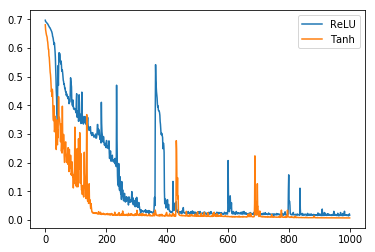

In [198]:
plt.plot(np.arange(len(relu_losses)), np.asarray(relu_losses),label='ReLU')
plt.plot(np.arange(len(tanh_losses)), np.asarray(tanh_losses),label='Tanh')
plt.legend()

#### Questions
- Observez la distribution du gradient lors de la backprop. Quelles différences y a-t-il entre la backprop à travers ReLU et à travers tanh?
- Est-ce que, pour deux entrées différentes, les mêmes poids ont un gradient élevé?
- Changez le nombre de couches du réseau. Qu'observez-vous?
- Changez la moyenne de la gaussienne des poids lors de l'initilisation. Qu'observez-vous?
- Identifiez un problème avec la tanh. Identifiez un problème avec la ReLU.